# **Long Term Prediction Using Time Series Forecasting**
The investors who want to invest in company's stock for long terms can make use of these algorithms to forecast future stock closing prices and movements. Three algorithms will be used for time series forecasting and they are :
*   Long Short Term Memory RNN
*   Recurrent Neural Networks
*   Convolutional Neural Networks




In [56]:
#installing all the necessary libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.utils import plot_model
from keras.layers import SimpleRNN
from keras.models import Sequential
import math
from sklearn.metrics import mean_squared_error
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.optimizers import Adam
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [57]:
#Fetching the data for the company stock prices from YahooFinance
data = yf.download('AAPL', start='2016-01-01', end=datetime.now())
#Converting the data into a dataframe
df = pd.DataFrame()
df = data

#Exploring the dataframa
print('The dataframe containing the company data is : \n', df.head(10))
print('The columns in the dataframe is : ', df.columns)
print('The shape of the dataframe is  : ', df.shape)
print('\n The description of the  dataframe is : \n', df.describe())
print('\n The information of the columns in the parameters dataframe is :')
print(df.info())

[*********************100%%**********************]  1 of 1 completed

The dataframe containing the company data is : 
                  Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2016-01-04  25.652500  26.342501  25.500000  26.337500  23.946920  270597600
2016-01-05  26.437500  26.462500  25.602501  25.677500  23.346823  223164000
2016-01-06  25.139999  25.592501  24.967501  25.174999  22.889936  273829600
2016-01-07  24.670000  25.032499  24.107500  24.112499  21.923876  324377600
2016-01-08  24.637501  24.777500  24.190001  24.240000  22.039803  283192000
2016-01-11  24.742500  24.764999  24.334999  24.632500  22.396673  198957600
2016-01-12  25.137501  25.172501  24.709999  24.990000  22.721724  196616800
2016-01-13  25.080000  25.297501  24.325001  24.347500  22.137543  249758400
2016-01-14  24.490000  25.120001  23.934999  24.879999  22.621716  252680400
2016-01-15  24.049999  24.427500  23.840000  24.282499  22.078442  319335600
The columns in the datafram

## **Outlier Detection of closing price**

Number of rows before removing outliers: 2095
Number of rows after removing outliers: 2095


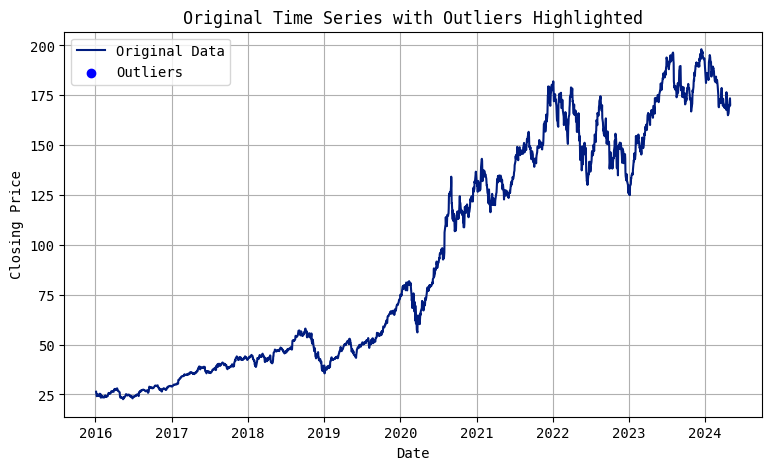

In [58]:
#Setting the graph style and the font style.
plt.style.use('seaborn-v0_8-dark-palette')
plt.rcParams["font.family"] = "monospace"

#Function definition for outlier_detection
def outlier_detection(df):

  # Calculate Z-score for each data point
  z_scores = np.abs((df['Close'] - df['Close'].mean()) / df['Close'].std())

  # Define a threshold for identifying outliers (e.g., z-score > 4 or < -4)
  threshold = 3

  # Identify outliers
  outliers = df[(z_scores > threshold) | (z_scores < -threshold)]

  # Print number of rows before and after removing outliers
  print("Number of rows before removing outliers:", len(df))
  print("Number of rows after removing outliers:", len(df) - len(outliers))

  # Remove outliers from the DataFrame
  df = df[(z_scores <= threshold) & (z_scores >= -threshold)]

  # Plot the cleaned time series
  plt.rcParams["figure.figsize"] = (9,5)
  plt.plot(df.index, df['Close'], label='Original Data')
  plt.scatter(outliers.index, outliers['Close'], color='blue', label='Outliers')
  plt.xlabel('Date')
  plt.ylabel('Closing Price')
  plt.title('Original Time Series with Outliers Highlighted')
  plt.legend()
  plt.grid()
  plt.show()


  return df

#Calling the function outlier_detection
df = outlier_detection(df)

## **Scaling the data**
Since algorithms like LSTM are really sensitive, the data has to be scaled.

In [59]:
#Selecting only the Close column from the dataframe.
df = df[['Close']]

#Performing min-max scaling
scaler = MinMaxScaler(feature_range=(0,1))
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

#Converting the df to a numpy array
df = np.array(df).reshape(-1,1)
print(df)

[[0.02137872]
 [0.01761858]
 [0.01475573]
 ...
 [0.83586385]
 [0.85979205]
 [0.84173196]]


### **Splitting the data into training and testing**

In [60]:
##splitting dataset into train and test split
training_size = int(len(df) * 0.75)
test_size = len(df) - training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]

print('The training size is : ', training_size)
print('\nThe test size is : ', test_size)


The training size is :  1571

The test size is :  524


## **Creation of the training data**
Here the algorithms will be using previous 100 days closing price  to predict the closing price of the next day. The timestep value will be assigned as 100 as 100 days previous closing price is input. The output column or the target variable is the Closing price of each trading day.

In [61]:
#Function definition to create the dataset for training and testing
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)


#Initializing the time step as 100 for previous 100 days closing price
time_step = 100

#Calling the function create_dataset to create the training data
X_train, y_train = create_dataset(train_data, time_step)

#Calling the function create_dataset to create the test data
X_test, y_test = create_dataset(test_data, time_step)

print('The shape of X_train is : ', X_train.shape)
print('\nX_train is : \n',X_train)
print('\nThe shape of y_train is : ', y_train.shape)
print('\ny_train is : \n', y_train)


print('\n\nThe shape of X_test is : ', X_test.shape)
print('\nX_test is : \n ', X_test)
print('\nThe shape of y_test is : ',y_test.shape)
print('\ny_test is : \n', y_test[0:20])

The shape of X_train is :  (1470, 100)

X_train is : 
 [[0.02137872 0.01761858 0.01475573 ... 0.00867398 0.0107677  0.0132175 ]
 [0.01761858 0.01475573 0.00870246 ... 0.0107677  0.0132175  0.0143427 ]
 [0.01475573 0.00870246 0.00942886 ... 0.0132175  0.0143427  0.01425723]
 ...
 [0.72476857 0.71998295 0.72602196 ... 0.81353086 0.83312922 0.84104832]
 [0.71998295 0.72602196 0.73439684 ... 0.83312922 0.84104832 0.86303949]
 [0.72602196 0.73439684 0.73137733 ... 0.84104832 0.86303949 0.86674263]]

The shape of y_train is :  (1470,)

y_train is : 
 [0.0143427  0.01425723 0.01355933 ... 0.86303949 0.86674263 0.87175619]


The shape of X_test is :  (423, 100)

X_test is : 
  [[0.88411909 0.86611594 0.86440676 ... 0.86349519 0.84851163 0.82600773]
 [0.86611594 0.86440676 0.8879362  ... 0.84851163 0.82600773 0.82407062]
 [0.86440676 0.8879362  0.86867966 ... 0.82600773 0.82407062 0.82577979]
 ...
 [0.95351088 0.9608603  0.95054831 ... 0.81615152 0.82219053 0.83426865]
 [0.9608603  0.95054831 0

# **Recurrent Neural Network (RNN)**
Recurrent Neural Network is one of the deep learning algorithms that will be used to implement time series forecasting.

### Reshaping the data for RNN model
The input data that has to be given to the Recurrent Neural Network has to be reshaped to match the input format for RNN models

In [62]:
#Reshaping the data
X_train_rnn =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test_rnn = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [63]:
#Designing the RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units = 50,
              activation = "tanh",
              return_sequences = True,
              input_shape = (100,1)))
model_rnn.add(Dropout(0.2))
model_rnn.add(SimpleRNN(units = 50,
              activation = "tanh",
              return_sequences = True))
model_rnn.add(Dropout(0.2))
model_rnn.add(SimpleRNN(units = 50,
              activation = "tanh",
              return_sequences = True))
model_rnn.add(Dropout(0.2))
model_rnn.add(SimpleRNN(units = 50))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(units = 1))

# Compiling the RNN model
model_rnn.compile(
    optimizer = "adam",
    loss = "mean_squared_error",
    metrics=['mse']
    )

#Training the RNN model
history_rnn = model_rnn.fit(X_train_rnn,
                        y_train,
                        validation_data=(X_test_rnn, y_test),
                        epochs = 100,
                        batch_size = 128)

Epoch 1/100
12/12 [==============================] - 8s 256ms/step - loss: 0.6185 - mse: 0.6185 - val_loss: 0.2955 - val_mse: 0.2955
Epoch 2/100
12/12 [==============================] - 2s 193ms/step - loss: 0.3736 - mse: 0.3736 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 3/100
12/12 [==============================] - 3s 266ms/step - loss: 0.2935 - mse: 0.2935 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 4/100
12/12 [==============================] - 2s 189ms/step - loss: 0.2642 - mse: 0.2642 - val_loss: 0.0216 - val_mse: 0.0216
Epoch 5/100
12/12 [==============================] - 2s 188ms/step - loss: 0.2190 - mse: 0.2190 - val_loss: 0.0208 - val_mse: 0.0208
Epoch 6/100
12/12 [==============================] - 2s 187ms/step - loss: 0.1750 - mse: 0.1750 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 7/100
12/12 [==============================] - 2s 170ms/step - loss: 0.1545 - mse: 0.1545 - val_loss: 0.0165 - val_mse: 0.0165
Epoch 8/100
12/12 [==============================] - 2s 210ms/step - 

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 100, 50)           2600      
                                                                 
 dropout_13 (Dropout)        (None, 100, 50)           0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 100, 50)           5050      
                                                                 
 dropout_14 (Dropout)        (None, 100, 50)           0         
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 100, 50)           5050      
                                                                 
 dropout_15 (Dropout)        (None, 100, 50)           0         
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 50)               

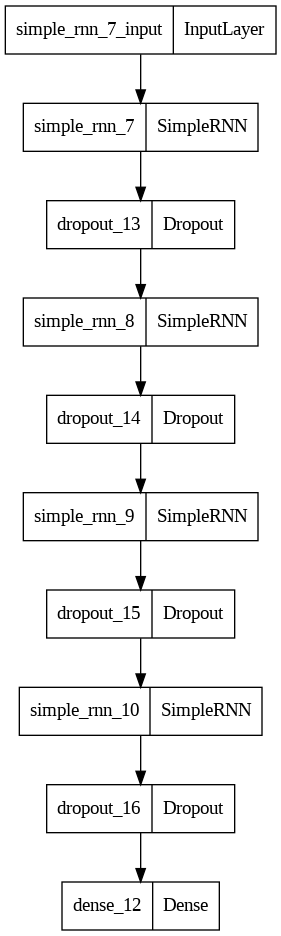

In [64]:
#Printing the model summary
print(model_rnn.summary())

#Plotting the model architecture
plot_model(model_rnn)

### Predicting using RNN model

In [65]:
#Predicting using the rnn model
#Predicting the values with X_train data
rnn_train_predict=model_rnn.predict(X_train_rnn)
#Predicting the values with X_test data
rnn_test_predict=model_rnn.predict(X_test_rnn)

#Trasnforming the data to back to the original form as it has been scaled
rnn_train_predict=scaler.inverse_transform(rnn_train_predict)
rnn_test_predict=scaler.inverse_transform(rnn_test_predict)

#Calculating the RMSE score for the model
### Calculate RMSE performance metrics
print('RMSE score of the y_train and train_predict : ', math.sqrt(mean_squared_error(y_train, rnn_train_predict)))
print('\nRMSE score of the y_test and test_predict : ',math.sqrt(mean_squared_error(y_test, rnn_test_predict)))


14/14 [==============================] - 0s 25ms/step
RMSE score of the y_train and train_predict :  89.40724941857363

RMSE score of the y_test and test_predict :  175.02053702611687


## **Plotting the actual data and predicted data using RNN model**

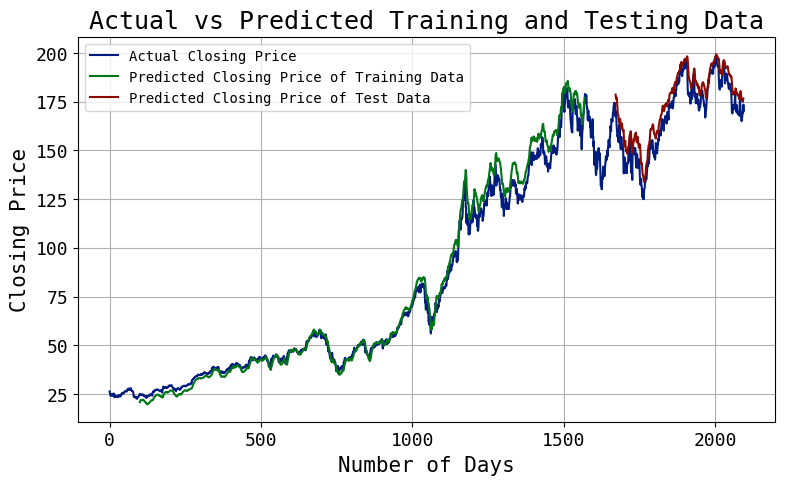

In [66]:
#Function definition for plot_actual_predicted

def plot_actual_predicted(df, train_predict, test_predict):

  #Assigning the look back value so that previous 100 days data can be used to  predict the next days closing price
  look_back=100
  trainPredictPlot = np.empty_like(df)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

  #shifting test predictions for plotting
  testPredictPlot = np.empty_like(df)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict

  #Plotting the actual data and predictions
  plt.title('Actual vs Predicted Training and Testing Data', fontsize = 18)
  plt.plot(scaler.inverse_transform(df), label = 'Actual Closing Price')
  plt.plot(trainPredictPlot, label = 'Predicted Closing Price of Training Data')
  plt.plot(testPredictPlot, label =     'Predicted Closing Price of Test Data')
  plt.xlabel('Number of Days', fontsize = 15)
  plt.ylabel('Closing Price', fontsize = 15)
  plt.xticks(fontsize = 13)
  plt.yticks(fontsize = 13)
  plt.grid()
  plt.legend()
  plt.show()

#Calling the function plot_actual_predicted
plot_actual_predicted(df, rnn_train_predict, rnn_test_predict)

## **Plotting the training  and validation mse and loss**

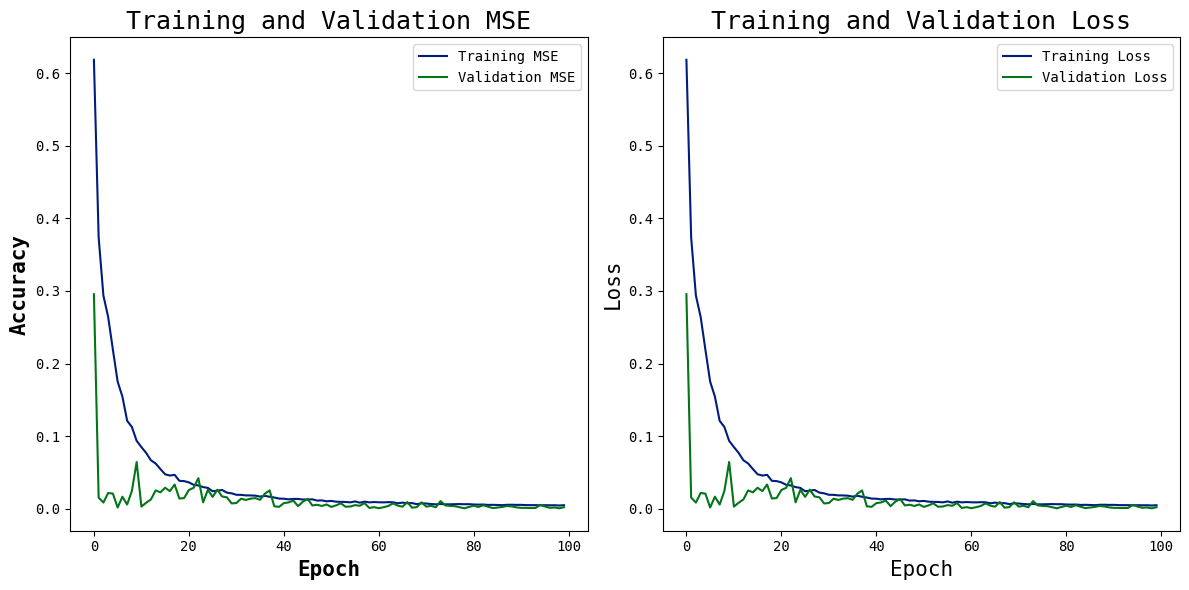

In [67]:
#Function definition for plotting training and validation mse and loss
def training_validation_mse_loss(history):

  # Plotting the graphs for  training and validation accuracy
  plt.figure(figsize=(12, 6))
  plt.style.use('seaborn-v0_8-dark-palette')
  plt.subplot(1, 2, 1)
  plt.plot(history.history['mse'], label='Training MSE')
  plt.plot(history.history['val_mse'], label='Validation MSE')
  plt.title('Training and Validation MSE',  fontsize = 18)
  plt.xlabel('Epoch', weight = 'bold', fontsize = 15)
  plt.ylabel('Accuracy', weight = 'bold', fontsize = 15)
  plt.legend()

  # Plotting the graphs for  training and validation loss
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Loss', fontsize = 18)
  plt.xlabel('Epoch', fontsize = 15)
  plt.ylabel('Loss', fontsize = 15)
  plt.legend()


  plt.tight_layout()
  plt.show()

#Calling the function training_validation_mse_loss
training_validation_mse_loss(history_rnn)

## **Forecasting the closing price movement for the next 30 days using LSTM model**

The output predicted is : 
 [[177.40348536848978], [179.27703919728083], [180.98401538444796], [183.1833173258883], [185.7647372036854], [186.8254482182365], [188.46454626579452], [189.35533176500485], [191.14577462877514], [192.47680552175098], [193.70277595264997], [195.45195627286012], [196.30974429174876], [197.33875512704344], [198.15310448445598], [198.93361939311762], [199.32948453592417], [200.10642140455093], [200.97511093723006], [201.29341003085938], [202.29011388478648], [202.45830269063663], [202.4544944842837], [202.90629004237235], [203.5064382545388], [203.78544168041662], [203.84863279682213], [203.8006117331961], [203.86813416122277], [204.06488451471978]]


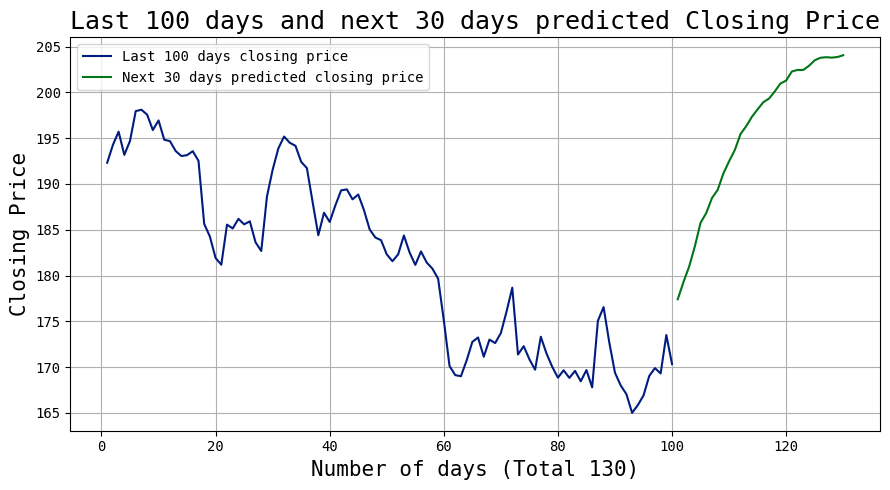

In [68]:
#Function definition predict_plot_30_days
def predict_plot_30_days(model):

  #Since we will be predicting for the next 30 days, we have to take the 100 days closing price data prior to the last day. (524-100)
  x_input = test_data[424:].reshape(1,-1)

  #Converting the above input data into a list
  temp_input =list(x_input)
  temp_input = temp_input[0].tolist()

  #Creating a list which will store the predicted values
  lst_output=[]
  n_steps=100
  i=0
  while(i<30):

    #Checking if the temp input list has more than 100 values every time
    if(len(temp_input)>100):
      x_input=np.array(temp_input[1:])
      x_input=x_input.reshape(1,-1)
      x_input = x_input.reshape((1, n_steps, 1))
      #Predicting the new days result
      yhat = model.predict(x_input, verbose=0)
      #Adding that to the temp_input list
      temp_input.extend(yhat[0].tolist())
      temp_input=temp_input[1:]
      #Adding the predicted value to the list lst_output
      lst_output.extend(yhat.tolist())
      i=i+1
    else:
      x_input = x_input.reshape((1, n_steps,1))
      #Predicting the next days closing price and assigning it into yhat
      yhat = model.predict(x_input, verbose=0)
      #Adding the predicted data into the temp input list so that it will act as the training data in the next iteration.
      temp_input.extend(yhat[0].tolist())
      #Adding the predicted yhat value to the lst_output list
      lst_output.extend(yhat.tolist())
      i=i+1

  #Printing the predicted output
  print('The output predicted is : \n', (scaler.inverse_transform(lst_output)).tolist())

  #Creating an array to store last 100 days data
  day_new=np.arange(1,101)
  #Creating an array to store next 30 days predicted data
  day_pred=np.arange(101,131)

  #Plotting the graph with the last 100 days and the next 30 days predicted data
  plt.plot(day_new,scaler.inverse_transform(df[1995:]), label = 'Last 100 days closing price')
  plt.plot(day_pred,scaler.inverse_transform(lst_output), label = 'Next 30 days predicted closing price')
  plt.title('Last 100 days and next 30 days predicted Closing Price', fontsize = 18)
  plt.xlabel('Number of days (Total 130)', fontsize = 15)
  plt.ylabel('Closing Price', fontsize = 15)
  plt.grid()
  plt.legend()
  plt.tight_layout()
  plt.show()

#Calling the function predict_plot_30_days
predict_plot_30_days(model_rnn)

# **Long Short Term Memory Recurrent Neural Network**
Long Short Term Memory is one of the deep learning algorithms that will be used to implement time series forecasting.

### Reshaping the data for LSTM model
The input data that has to be given to the LSTM neural network has to be reshaped as the input is expected to be three dimensional which includes samples, time-steps and features and the original data that we have is two dimensional.

In [69]:
#Reshaping the data for the LSTM model.
X_train_lstm =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test_lstm = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [70]:
#Creating and designing the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(128,return_sequences=True,input_shape=(100,1)))
model_lstm.add(LSTM(50,return_sequences=True))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam', metrics=['mse'] )


#Training the LSTM model
history_lstm  = model_lstm.fit(X_train_lstm, y_train, validation_data=(X_test_lstm,y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
23/23 [==============================] - 18s 455ms/step - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 2/100
23/23 [==============================] - 9s 378ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 3/100
23/23 [==============================] - 10s 417ms/step - loss: 6.7101e-04 - mse: 6.7101e-04 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 4/100
23/23 [==============================] - 10s 421ms/step - loss: 6.6083e-04 - mse: 6.6083e-04 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 5/100
23/23 [==============================] - 10s 434ms/step - loss: 6.4607e-04 - mse: 6.4607e-04 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 6/100
23/23 [==============================] - 8s 366ms/step - loss: 6.0766e-04 - mse: 6.0766e-04 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 7/100
23/23 [==============================] - 9s 414ms/step - loss: 5.6528e-04 - mse: 5.6528e-04 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 8/100
23/23 [======

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100, 128)          66560     
                                                                 
 lstm_13 (LSTM)              (None, 100, 50)           35800     
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 122611 (478.95 KB)
Trainable params: 122611 (478.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


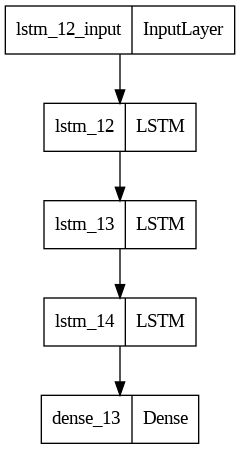

In [71]:
#Printing the model summary
print(model_lstm.summary())

#Plotting the model architecture
plot_model(model_lstm)

### Predicting using the LSTM model

In [72]:
#Predicting using the LSTM model
#Predicting the values with X_train data
lstm_train_predict=model_lstm.predict(X_train_lstm)
#Predicting the values with X_test data
lstm_test_predict=model_lstm.predict(X_test_lstm)

#Trasnforming the data to back to the original form as it has been scaled
lstm_train_predict=scaler.inverse_transform(lstm_train_predict)
lstm_test_predict=scaler.inverse_transform(lstm_test_predict)

#Calculating the RMSE score for the model
### Calculate RMSE performance metrics
print('RMSE score of the y_train and train_predict : ', math.sqrt(mean_squared_error(y_train, lstm_train_predict)))
print('\nRMSE score of the y_test and test_predict : ',math.sqrt(mean_squared_error(y_test, lstm_test_predict)))


14/14 [==============================] - 1s 79ms/step
RMSE score of the y_train and train_predict :  88.00950916855997

RMSE score of the y_test and test_predict :  173.18773525167737


## **Plotting the actual data and predicted data using LSTM**

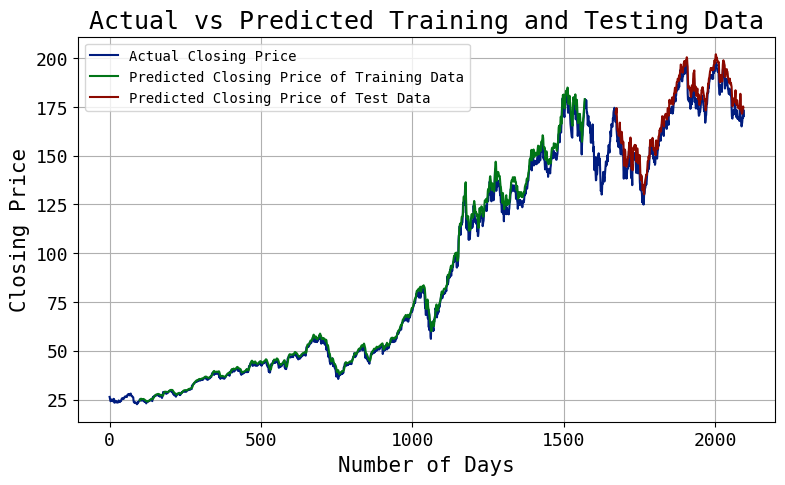

In [73]:
#Calling the function plot_actual_predicted
plot_actual_predicted(df, lstm_train_predict, lstm_test_predict)

## **Plotting the training  and validation mse and loss**

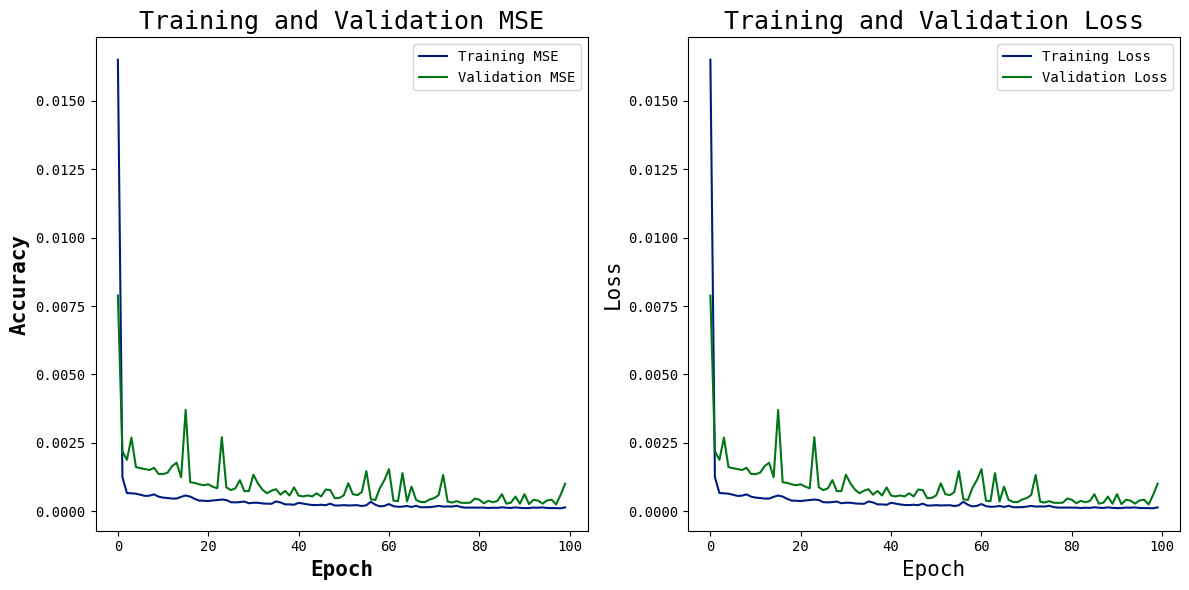

In [74]:
#Calling the function training_validation_mse_loss
training_validation_mse_loss(history_lstm)

## **Forecasting the closing price movement for the next 30 days using LSTM model**

The output predicted is : 
 [[176.16442684377898], [179.3599304580889], [183.31773445561976], [186.93590712668174], [190.00634673345667], [192.62794109585593], [194.9671318481337], [197.1561809263162], [199.26409637739198], [201.30625749624778], [203.2686764480104], [205.13034532510665], [206.87661718002528], [208.50364195799193], [210.01665071168918], [211.42621016753583], [212.74437267091253], [213.9827511587746], [215.15149387332622], [216.25949360412778], [217.3146387786246], [218.3241691737294], [219.29455037055777], [220.2318085418001], [221.141091043296], [222.0268128835096], [222.89257302668648], [223.74125901390744], [224.5750260388777], [225.3953597205591]]


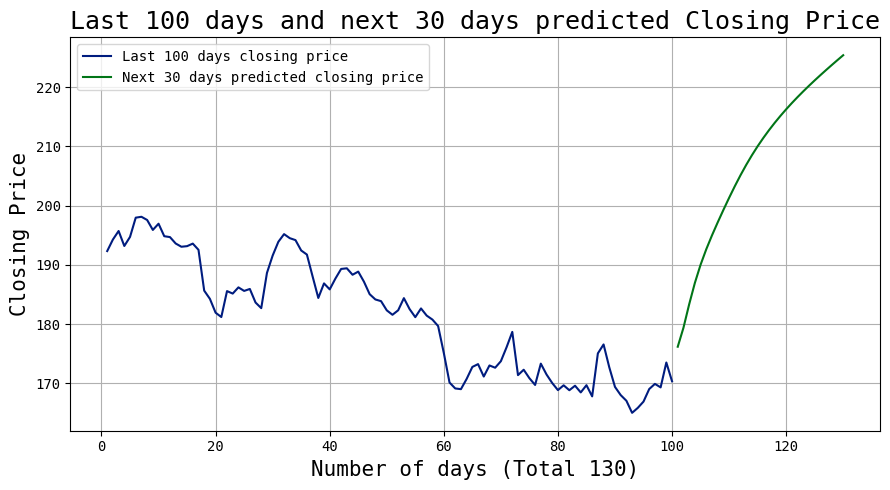

In [75]:
#Calling the function predict_plot_30_days
predict_plot_30_days(model_lstm)

# **Convolutional Neural Network CNN**
Convolutional Neural Network will be one of the deep learning algorithms which will be used to implement time series forecasting

### **Reshaping the data for CNN model**

In [76]:
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [77]:
#Creating and designing the CNN model
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100, 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))  # Output layer, no activation function for regression

# Compile the CNN model
model_cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

# Training the CNN model
history_cnn = model_cnn.fit(X_train_cnn, y_train, validation_data=(X_test_cnn, y_test), epochs = 100, batch_size=64, verbose=1)

Epoch 1/100
23/23 [==============================] - 2s 27ms/step - loss: 0.0336 - mse: 0.0336 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 2/100
23/23 [==============================] - 0s 19ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 3/100
23/23 [==============================] - 0s 20ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 4/100
23/23 [==============================] - 0s 18ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 5/100
23/23 [==============================] - 0s 21ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 6/100
23/23 [==============================] - 0s 19ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 7/100
23/23 [==============================] - 0s 20ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 8/100
23/23 [==============================] - 0s 19ms/step - loss: 0.

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 98, 64)            256       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 49, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 47, 32)            6176      
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 23, 32)            0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 736)               0         
                                                                 
 dense_14 (Dense)            (None, 50)              

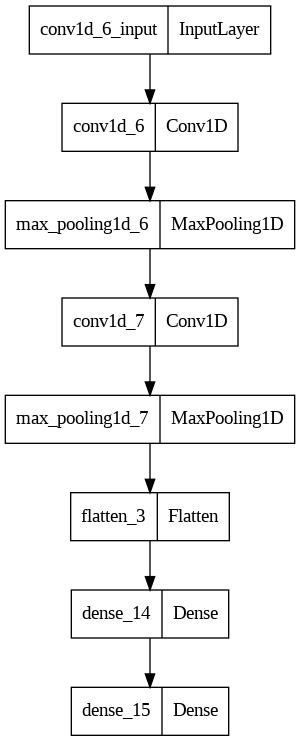

In [78]:
#Printing the model summary
print(model_cnn.summary())

#Plotting the model architecture
plot_model(model_cnn)

### Predicting using the LSTM model

In [79]:
#Predicting using the CNN model
#Predicting the values with X_train data
cnn_train_predict=model_cnn.predict(X_train_cnn)
#Predicting the values with X_test data
cnn_test_predict=model_cnn.predict(X_test_cnn)

#Trasnforming the data to back to the original form as it has been scaled
cnn_train_predict=scaler.inverse_transform(cnn_train_predict)
cnn_test_predict=scaler.inverse_transform(cnn_test_predict)

#Calculating the RMSE score for the model
### Calculate RMSE performance metrics
print('RMSE score of the y_train and train_predict : ', math.sqrt(mean_squared_error(y_train, cnn_train_predict)))
print('\nRMSE score of the y_test and test_predict : ',math.sqrt(mean_squared_error(y_test, cnn_test_predict)))


14/14 [==============================] - 0s 4ms/step
RMSE score of the y_train and train_predict :  84.98140871423094

RMSE score of the y_test and test_predict :  170.23802847529927


## **Plotting the actual data and predicted data using CNN**

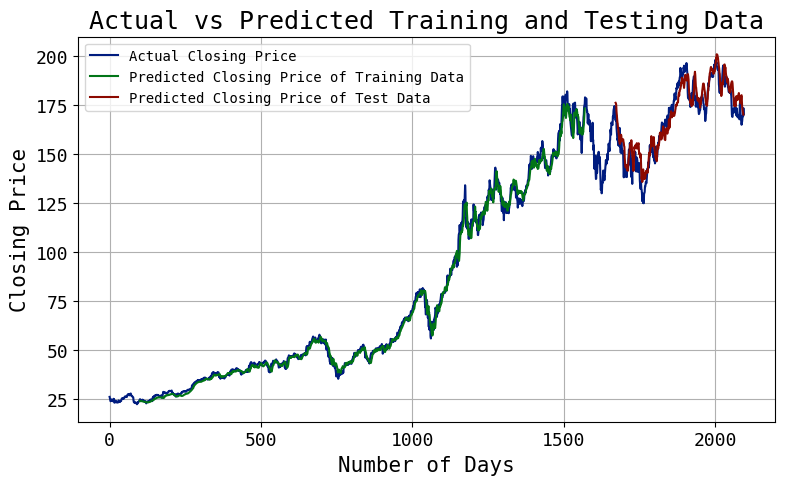

In [80]:
#Calling the function plot_actual_predicted
plot_actual_predicted(df, cnn_train_predict, cnn_test_predict)

## **Plotting the training  and validation mse and loss**

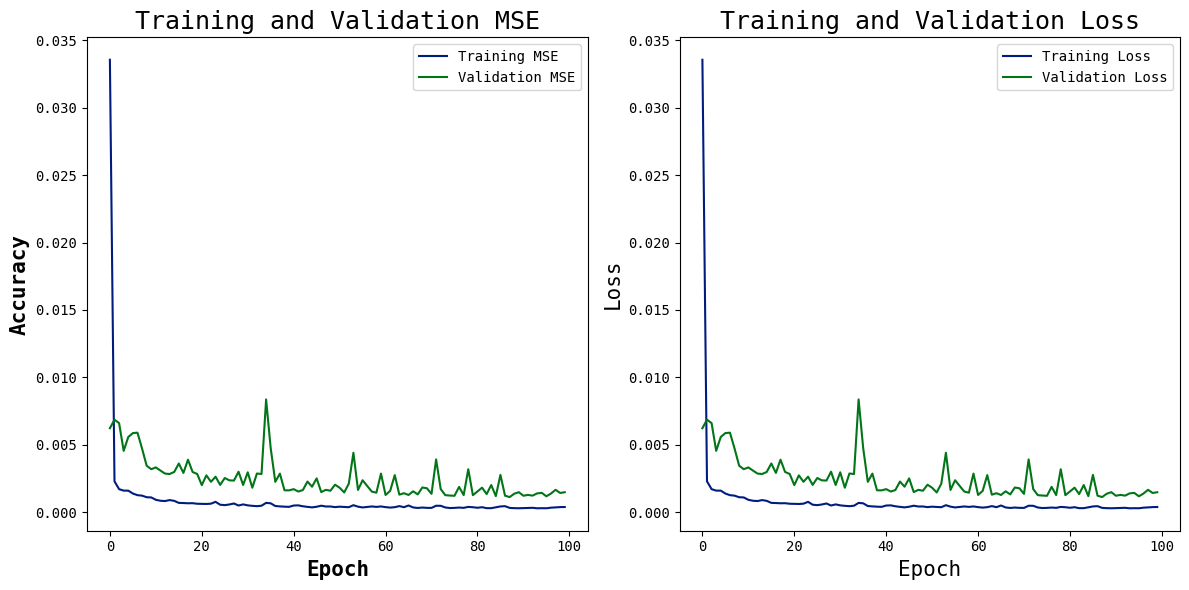

In [81]:
#Calling the function training_validation_mse_loss
training_validation_mse_loss(history_cnn)

## **Forecasting the closing price movement for the next 30 days using CNN model**

The output predicted is : 
 [[175.42354239024053], [177.47744199131603], [177.80227990079857], [180.39288550710626], [182.57143063150215], [184.12948921090174], [185.65376565207725], [186.76290575236362], [189.35518529552974], [192.26072119753917], [193.7897683587612], [195.59939872377117], [196.78925396694967], [198.39463264891583], [199.56467266453274], [199.13300619716665], [200.03333313647], [200.5853138155353], [201.45036253554736], [200.32694166143756], [202.0080345999313], [202.28088630785442], [201.7982275389386], [201.36281563785178], [202.52971702185914], [202.37514987719442], [201.27658696543222], [200.90827900815748], [201.38702494966674], [200.88802437217055]]


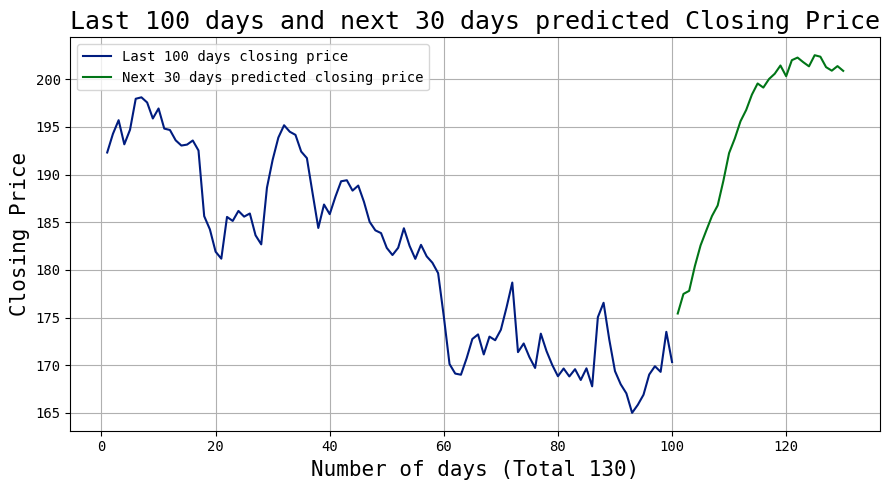

In [82]:
#Calling the function predict_plot_30_days
predict_plot_30_days(model_cnn)